# Prácticas ESAC: Strömgren Radius Kerutt22

1. Filter in redshift
2. $C_H$ interpolation
3. Strömgren Radius
4. Strömgren comovil radius
5. Strömgren radius with Yajima Relation

   Appendix A: Saving data

$\textit{Juan A. Molina-Calzada}$

En este cuaderno, se van a calcular los radios de Strömgren con el objetivo de estimar el tamaño de las burbujas ionizadas durante el fin de la época de la reionizazión, entorno a z = 6-7. Como acabamos de decir, estos cálculos se tratan de una mera estimación puesto que calcularemos un límite superior al radio de estas burbujas.

In [1]:
# Paquetes
from astropy.table import Table, QTable, unique
from astropy.io import ascii
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import smplotlib
from uncertainties import ufloat, unumpy
import sys

# Definimos Mpc en unidades propias comóviles
pMpc = u.def_unit('pMpc')
cMpc = u.def_unit('cMpc')

## 1. Filter in redshift

Utilzaremos los datos de Kerutt22 para la realización de este cuaderno escogiendo únicamente aquellas galaxias con z > 6, puesto que estas son las únicas para las cuales el Universo todavía no estaba completamente reionizado y por tanto, estas esferas tenían un tamaño finito (no ocupaban todo el universo). 

In [5]:
# Leemos datos
Kerutt22 = QTable.read('/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/models/tableb1_Kerutt22_model_v1.dat', format = 'ascii', delimiter = ' ')
Kerutt22_filter = Kerutt22[Kerutt22['z'] > 6]
Kerutt22_filter

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078


## 2. $C_H$ interpolation

En esta sección, definimos el coeficiente de recombinación $\alpha_B$, la densidad de hidrógeno $n_H$ y la constante $C_H$. 

El primero, asumiendo una $T_e = 10^4\,K$ tiene un valor de $\alpha_B = 8.8 \cdot 10^{.87} pMpc^{3}/s$ donde $pMpc$ son las unidades, en distancia propia, de $Mpc$. Por otro lado, tendremos $cMpc$, las cuales se referirán a unidades comóviles en $Mpc$. En segundo lugar, $n_H$ es el parámetro de densidad de hidrógeno, el cual depende del redshift como

$$
\begin{equation}
    n_H(z) = 5.878 \cdot 10^{66} (1+z)^{3} Mpc^{-3}.
\end{equation}
$$

Por último, el parámetro C_H depende del reshift y sus valores son C_H(z = 8) = 2.19, C_H(z = 7) = 2.28, C_H(z = 6) = 2.37. Para valores intermedios, interpolaremos. 

In [3]:
# C_H 
def C_H(z):
    z_values = [6 ,7 , 8]
    C_H_values = [2.37, 2.28, 2.19]
    C_H = np.interp(z, z_values,C_H_values) 
    return C_H

# alphaB (coeficiente de recombinación para T_e = 10⁴K)
alphaB = 8.8 * 10**(-87)

# n_H (densidad de hidrógeno)
def n_H (z):
    n_H = 5.878 * 10**66 * (1+z)**3
    return n_H

## 3. Strömgen Radius

Ya es el momento de estimar el radio de Strömgen, o mejor dicho, el límite superior al tamaño de estas burbujas para cada galaxia a z > 6. Este radio se define como:

$$
\begin{equation}
    R_s^{1/3} = \frac{3 \dot{N}_{ion}}{4\pi C_H \langle n_H \rangle ^ 2 \alpha_B}
\end{equation}
$$

donde $\dot{N}_{ion}$ se corresponde con el número de fotones del continuo ionizante, según las definciones en [Reionized-Bubble-published](https://watermark.silverchair.com/mnrasl_495_1_l17.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA3UwggNxBgkqhkiG9w0BBwagggNiMIIDXgIBADCCA1cGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMesIRyAw1IMhjJgxLAgEQgIIDKNLnPEZWRv4H07eC47gxYs3YVUGv5PmSrfVEViCuE9OGjq7ro9MHhMyPmAakzFX36UUoujJ_iE9CnliM-I7rMh4z7mOeffZzdY6hfOyq00dea8-Lq1pWKHV4W24VMD60GNXdkNjd2aavHQncseS1xETCLGjWV75goKbuh_yg9nXTHI6v6S2MA0fKTlzk56zTvu3069rRq-WpUdLuyv0U6NSQNNtqfWMR468NbLLTfIHve9wfcSxGB-iHQiIJD0nQVAkDzO-LT1nxBzsiES0EvVeGqMNtyfLWRrMX8NxIJaaGEljDw5QQtk3ogx7j5QCeYpUBYY7__mlZBc8-pdDzOQ5ALXsasW69Qkf1sSmFzIvTPaMEK9YUN8axtA9iJViI5U33clBDs8xa0nJi5GA1IsnB9Elr1WP06eTj6v-HQeNqO5w4vP9vKIYTsDRvFzuu6U-Ok0Kw0aH2ybnJAVYQ8qfFRo29CcuPwsu8UVwCpISBnRl-269GGOHYzPoEzJrp_dWBnvXTYh6TTl0178RJhmDySOlH5Ie4tMfe-dp4cdQnhl0z-x4MQRIG_SDb3Xo-crH844EffwRQ5EnsktfdoMwXXvndvakMYFzSCSYEnJU1ZhMCUPH3IeyMQS1IXNM05Qm8QGW1OlUrqIvLDMjlCZeWptQ6X7mX5lX9jph4M9eKAelJw-dZjqlhm6NHjGS7FjhfsczkoehMAi87W5bm6FPbQlTpzEdDoNfMcc3GPH1SEbdltmN8j6TrfTA5pk2JFqntSzJJC99DHJzDeSWGumc1zg4FrP7vkUC4yAGgoMsSac6IL_SpwXEKc9sKB9ezu5PVy4NrWL7sc-xSmau0sVn8g_wP25TePV25N4Z8GxAE1cV_PPHKOFJU21pomgFaZdxyPxENLoyx9v64JuoXhi48PWuV9V1JPAXatkS2q3VTz5hRGiUD9nxqy7DbU6jVmZwqErVDNamfyN_0H7VxMEOm5sa65jZyHaGtyknwQq6fktLmskgK_kmotgnM2rZWexXFBGzK5USVEwHe-iA7Ri0pKvudfX8MtFVjs8HZGOqBvO118nGdD3Q). Esto es,

$$
\begin{equation}
    \dot{N}_{ion} = \frac{Q_{ion}}{1-f_{esc,LyC}} \cdot f_{esc,LyC}
\end{equation}
$$

donde $Q_{ion}$ se corresponde con los valores de $10^{logN_{ion}}$ de la tabla de Kerutt22 $\textbf{(cuidado con la notación)}$. Se asume $f_{esc,LyC} = 0.2$, valor estimador por diversos autores. 

In [4]:
# Strömgen radius
f_esc_LyC = 0.2
N_ion = (10**Kerutt22_filter['logN_ion'].value) / (1 - f_esc_LyC) * f_esc_LyC

R_s = (3 * N_ion / (4 * np.pi * C_H(Kerutt22_filter['z']) * n_H(Kerutt22_filter['z'])**2 * alphaB))**(1/3)
Kerutt22_filter['R_s'] = np.round(R_s,3) * pMpc
Kerutt22_filter

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model,R_s
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,,pMpc
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0,0.496
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0,0.373
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578,0.777
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377,0.805
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0,0.568
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442,0.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078,2.176


### 3.1. Strömgren Radius errors

El error en el radio de Strömgen se calcula directamente con la función de uncertainties de Python.

In [5]:
# Errors in Strömgen Radius
N_unc = unumpy.uarray(N_ion, (10**Kerutt22_filter['logN_ion'].value*Kerutt22_filter['e_logN_ion'].value) / (1 - f_esc_LyC) * f_esc_LyC)
C_H_unc = unumpy.uarray(C_H(Kerutt22_filter['z']),0)
n_H_unc = unumpy.uarray(n_H(Kerutt22_filter['z']),0)

e_R_s_values =  (3 * N_unc / (4 * np.pi * C_H_unc * n_H_unc**2 * alphaB))**(1/3)

e_R_s = []
for i in range(len(e_R_s_values)):
    e_R_s.append(e_R_s_values[i].std_dev)

Kerutt22_filter['e_R_s'] = np.round(e_R_s,3) * pMpc
Kerutt22_filter

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model,R_s,e_R_s
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,,pMpc,pMpc
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0,0.496,0.013
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0,0.373,0.031
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578,0.777,0.034
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377,0.805,0.045
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0,0.568,0.025
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442,0.401,0.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078,2.176,0.062


## 4. Strömgren comovil raidus

Por último, reescalamos este radio calculado a distancia cómovil. Nótese que $pMC$ y $cMpc$ son unidades de longitud en $Mpc$ para distancias propias y comóviles respectivamente. Añadiremos estas unidades en la QTable.

In [6]:
# Strömgen proper radius to comovil
Kerutt22_filter['R_s_com'] = np.round(Kerutt22_filter['R_s'].value * (1 + Kerutt22_filter['z']),3) * cMpc
Kerutt22_filter['e_R_s_com'] = np.round(Kerutt22_filter['e_R_s'].value * (1 + Kerutt22_filter['z']),3) * cMpc
Kerutt22_filter

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model,R_s,e_R_s,R_s_com,e_R_s_com
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,,pMpc,pMpc,cMpc,cMpc
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0,0.496,0.013,3.494,0.092
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0,0.373,0.031,2.63,0.219
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578,0.777,0.034,5.515,0.241
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377,0.805,0.045,5.717,0.32
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0,0.568,0.025,4.04,0.178
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442,0.401,0.034,2.905,0.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078,2.176,0.062,16.38,0.467


## 5. Strömgren Radius with Yajima Relation

En esta sección, vamos a estimar nuevamente el radio de Strömghen utilizando la relación de la _Figura 13 de Yajima (Hidenobu Yajima, et al. (2008)_.

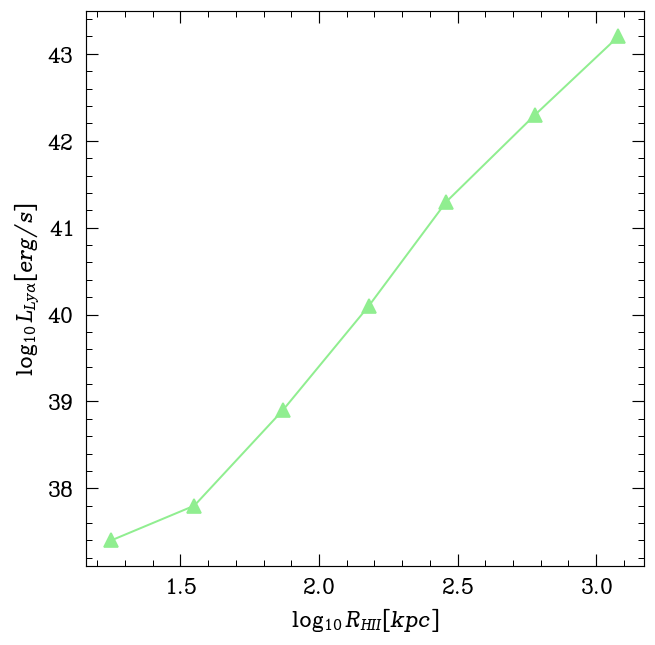

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model,R_s,e_R_s,R_s_com,e_R_s_com,R_HII
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,,pMpc,pMpc,cMpc,cMpc,pMpc
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0,0.496,0.013,3.494,0.092,0.6
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0,0.373,0.031,2.63,0.219,0.427
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578,0.777,0.034,5.515,0.241,0.706
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377,0.805,0.045,5.717,0.32,0.596
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0,0.568,0.025,4.04,0.178,0.69
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442,0.401,0.034,2.905,0.246,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078,2.176,0.062,16.38,0.467,1.387


In [7]:
# Fig. 13 Yajima
logRHII = [1.25, 1.55, 1.87, 2.18, 2.46, 2.78, 3.08]
logLLya = [37.4, 37.8, 38.9, 40.1, 41.3, 42.3, 43.2]

plt.plot(logRHII, logLLya, marker = '^', color = 'lightgreen')
plt.xlabel(r'$\log_{10}R_{HII} [kpc]$')
plt.ylabel(r'$\log_{10}L_{Ly \alpha} [erg/s]$')

# Ajuste polinómico de n orden
n = 5
coefficients = np.polyfit(logLLya, logRHII, n)
poly_fit = np.poly1d(coefficients)

# Visualización del ajuste y puntos encontrados
logLLya_fit = np.linspace(min(logLLya), max(logLLya), 100)
logRHII_fit = poly_fit(logLLya_fit)

#plt.plot(logRHII_fit, logLLya_fit, '--',label = 'fit',color='green')
#plt.legend(fontsize = 12, frameon = True)
plt.show()

# Función que calcula EW a partir de HSC-y - Hu18DECam-NB964
def calculate_RHII(logLLya_value):
    return poly_fit(logLLya_value)

logRHII = np.round(calculate_RHII(Kerutt22_filter['logLLya'].value),3)
Kerutt22_filter['R_HII'] = ((np.round((10**logRHII * u.kpc).to(u.Mpc),3)).value) * pMpc
Kerutt22_filter

### 5.1. Errors in Strömghen Radius with Yajima Relation 

In [45]:
# Consideramos un error del 20% en el ajuste
Kerutt22_filter['e_R_HII'] = np.round(0.2 * Kerutt22_filter['R_HII'],3)
Kerutt22_filter

ID,I17ID,RAdeg,DEdeg,z,e_z,Conf,EW0,e_EW0,MUV,e_MUV,logLLya,e_logLLya,Peaksep,e_Peaksep,FWHM,e_FWHM,Asym,e_Asym,Re,e_Re,axisratio,e_axisratio,f_esc_Lya,e_f_esc_Lya,logLLya_int,e_logLLya_int,logN_ion,e_logN_ion,logL1200,e_logL1200,f_esc_Lya_model,e_f_esc_Lya_model,R_s,e_R_s,R_s_com,e_R_s_com,R_HII,e_R_HII
,,deg,deg,,,,Angstrom,Angstrom,mag,mag,dex(erg / s),dex(erg / s),km / s,km / s,km / s,km / s,,,kpc,kpc,,,,,dex(erg / s),dex(erg / s),dex(1 / s),dex(1 / s),dex(erg / (Angstrom s)),dex(erg / (Angstrom s)),,,pMpc,pMpc,cMpc,cMpc,pMpc,pMpc
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13444244,6102,53.17014,-27.80877,6.0438,0.002,2,553.37,0.0,-16.621,0.0,42.33,0.41,109.97,141.55,108.91,70.16,0.27,0.08,1.6,0.75,1.0,0.0,1.0,0.0,42.33,0.178,53.254,0.077,39.587,0.178,1.0,0.0,0.496,0.013,3.494,0.092,0.6,0.12
13464246,0,53.13985,-27.7814,6.0503,0.0148,1,150.5,0.0,-16.741,0.0,41.82,1.31,0.0,0.0,370.23,103.53,0.19,0.11,1.0,0.0,1.0,0.0,0.722,0.0,41.961,0.569,52.885,0.248,39.642,0.569,1.0,0.0,0.373,0.031,2.63,0.219,0.427,0.085
13694272,0,53.16439,-27.76205,6.0972,0.0064,2,88.09,26.45,-19.172,0.122,42.56,0.64,0.0,0.0,239.46,66.31,0.19,0.09,1.0,0.0,1.0,0.0,0.423,0.127,42.934,0.307,53.858,0.133,40.615,0.307,0.815,0.578,0.777,0.034,5.515,0.241,0.706,0.141
13754278,0,53.17925,-27.77322,6.1024,0.0011,2,45.39,16.66,-19.303,0.117,42.32,0.81,341.43,38.11,141.28,61.41,0.23,0.09,2.41,1.28,1.0,0.0,0.218,0.08,42.982,0.386,53.906,0.168,40.663,0.386,0.42,0.377,0.805,0.045,5.717,0.32,0.596,0.119
13774280,6283,53.18745,-27.77795,6.1118,0.006,2,864.36,0.0,-16.629,0.0,42.53,0.71,0.0,0.0,241.63,56.93,0.24,0.07,1.0,0.0,1.0,0.0,1.0,0.0,42.53,0.308,53.454,0.134,39.593,0.308,1.0,0.0,0.568,0.025,4.04,0.178,0.69,0.138
13974303,6524,53.15823,-27.76767,6.2446,0.0102,2,105.99,0.0,-17.152,0.0,41.83,1.35,0.0,0.0,40.98,55.64,0.03,0.11,1.0,0.0,1.0,0.0,0.509,0.0,42.123,0.587,53.047,0.255,39.805,0.586,0.98,1.442,0.401,0.034,2.905,0.246,0.43,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201073224,0,150.09508,2.19818,6.5277,0.0019,2,16.89,0.0,-22.904,0.023,43.33,0.46,0.0,0.0,144.19,56.93,0.39,0.09,11.76,0.0,0.78,0.0,0.081,0.0,44.422,0.199,55.346,0.086,42.102,0.2,0.156,0.078,2.176,0.062,16.38,0.467,1.387,0.277


## Appendix A: Saving data

Si se ejecuta el siguiente código, guardaremos y sobreescribiremo los datos. Nótese que lo guardamos en formato ecsv (formato profesional para astrofísica)

In [41]:
ascii.write(Kerutt22_filter, 'Kerutt22_filter_v1.dat', format='ecsv', overwrite=True)  

In [43]:
# To LaTeX
data_table = ascii.read('Kerutt22_filter_v1.dat', format='ecsv')
df = data_table.to_pandas()[:7]
path = '/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/latex_tables/Kerutt22.tex'
cols = ['ID', 'z', 'EW0', 'logLLya', 'f_esc_Lya', 'R_s', 'R_HII']
df.to_latex(buf=path ,columns= cols, float_format='%.2f',header=True, index=False, position= 'H', label = 'Kerutt22', caption = 'Kerutt22')